<center> <h1>Workshop: Causal Lasso</h1> </center> 
<center> <h2>Application: Algorithmic Targeting</h2> </center> 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from statsmodels.api import add_constant

### 0. Setting
You are in charge of email marketing at a startup. Suppose you want to assess the effectiveness of different advertising channels and found that (when analyzing historical data) there is little relationship between ad exposure through email marketing and revenue generated. It is however also the case that your email marketing is sent to customers based on an alogrithm that takes their behavioral data as an input. Specifically, each customer in your data is assessed in terms of recency, frequency, and monetary value (RFM) on a 1 to 10 scale (10 being more favorable, i.e. higher frequency, more recent purchase, etc.). The algorithm uses this information (but no other input such as demographic information) to prioritize certain groups of customers. While you know which input variables are used in the algorithm, the actual targeting strategy is a bit of a black box. However, you wonder if targeting puts into question your findings based on historical data. You therefore want to formally measure the impact of email marketing while also accounting for the influence of the targeting algorithm.



### 1. Treatment regressions

#### 1.1. Drivers of ad-exposure

**Q:** : Load the data and regress ad_exposure (this is the “treatment” in this context) on recency, frequency, and monetary value. What do you find?

In [2]:
algo_ads = pd.read_csv('algo_ads.csv')
algo_ads.head()

,consumer_id,revenue,ad_exposure,recency,frequency,monetary_value,age,mobile
0,1,50.108791,0,10,7,5,24,1
1,2,46.752033,1,4,6,6,56,1
2,3,58.066216,1,4,5,10,33,1
3,4,36.502415,0,1,2,5,52,1
4,5,41.131004,1,2,6,5,36,1


In [3]:
exposure_rfm_reg  = smf.ols(formula = 'ad_exposure ~ recency + frequency + monetary_value', data = algo_ads).fit()
print(exposure_rfm_reg.summary())

                            OLS Regression Results                            
Dep. Variable:            ad_exposure   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     109.1
Date:                Sun, 06 Mar 2022   Prob (F-statistic):           7.23e-68
Time:                        22:55:20   Log-Likelihood:                -2733.7
No. Observations:                4000   AIC:                             5475.
Df Residuals:                    3996   BIC:                             5501.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.9100      0.026     34.

**A:** Based on this regression, customers with higher frequency and recency are significantly less likely to be exposed to an ad. Monetary value is insignificant.

#### 1.2 Lasso on drivers of ad exposure

**Q:** Run a cross-validated lasso where ad exposure is the outcome variable and the three different RFM variables are the candidate X-variables. What do you find? Relate this finding to the regression you ran in 1.1. Plot the mean square error and print non-zero coefficients.

In [26]:
from scipy import sparse
from sklearn.linear_model import LassoCV

In [27]:
# X variables to try for LASSO
X = sparse.csc_matrix(algo_ads[['recency','frequency','monetary_value']])

# Y variable for LASSO
Y = algo_ads['ad_exposure']

# We run CV Lasso
nfolds  = 10
lassocv = LassoCV(alphas = None, cv = nfolds, max_iter = 10000) #letting Lasso CV to choose alpha automatically
lassocv.fit(X,Y)

LassoCV(cv=10, max_iter=10000)

In [28]:
def plot_lassoCV(lasso,nfolds):
     #1se rule 
    mean = np.mean(lasso.mse_path_, axis=1)
    std_error = np.std(lasso.mse_path_, axis=1)/np.sqrt(nfolds)
    mean_min  = mean[lasso.alphas_==lasso.alpha_]
    std_min   = std_error[lasso.alphas_==lasso.alpha_]
    alpha_1se = np.max(lasso.alphas_[mean <= mean_min + std_min])

    # Plot    
    plt.semilogx(lasso.alphas_, np.mean(lasso.mse_path_, axis=1))

    plt.semilogx(lasso.alphas_, mean + std_error, "b--")
    plt.semilogx(lasso.alphas_, mean - std_error, "b--")
    plt.fill_between(lasso.alphas_, mean + std_error, mean - std_error, alpha=0.2)
    plt.axvline(lasso.alpha_, linestyle="--", color="black", label="$\lambda_{min}$")
    plt.axvline(alpha_1se, linestyle="--", color="red", label="$\lambda_{1se}$")
    plt.legend()
    plt.xlabel("$\log(\lambda)$")
    plt.ylabel("Mean Squared Error")
    plt.show() 

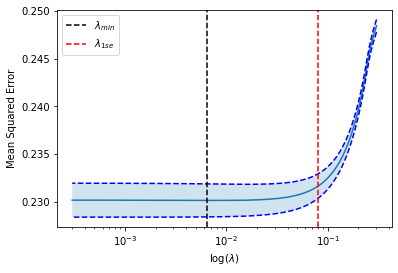

In [29]:
plot_lassoCV(lassocv,nfolds)

In [30]:
def get_coef(lasso,scale,coeffnames):
    # getting the coefficients and picking those that are not zero
    coefficients = np.append(lasso.intercept_, lasso.coef_/scale) 
    coeffnames = coeffnames[coefficients != 0]
    coeffvalues = coefficients[coefficients != 0]
    # return non-zero ones 
    return pd.DataFrame([coeffnames, coeffvalues]).T


In [31]:
coeffnames = np.array(['(Intercept)', 'recency','frequency','monetary_value'])
get_coef(lassocv,1,coeffnames)

,0,1
0,(Intercept),0.899284
1,recency,-0.035449
2,frequency,-0.029978


**A:** Only recency and frequency are maintained. Monetary value (which was insignificant earlier) is not retained.

### 2. Causal impact of ad exposure on revenue

**Q:** Run a regression of revenue on ad exposure. 

In [32]:
simple_reg  = smf.ols(formula = 'revenue ~ ad_exposure', data = algo_ads).fit()
print(simple_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.193
Date:                Sun, 06 Mar 2022   Prob (F-statistic):              0.139
Time:                        22:58:51   Log-Likelihood:                -14816.
No. Observations:                4000   AIC:                         2.964e+04
Df Residuals:                    3998   BIC:                         2.965e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      45.5617      0.229    199.095      

#### First Stage

**Q:** Run a cross-validated lasso where ad exposure is the outcome variable, but now allow for separate coefficients for each different level (1 to 10) of each of the three different RFM variables. What can you observe from the estimated coefficients? Compare to your answer in part 1. Plot the mean square error and print non-zero coefficients.

In [33]:
# get only the columns that we will use
algo_ads_X = pd.concat([algo_ads['recency'],algo_ads['frequency'],algo_ads['monetary_value']],axis=1)

# make categorical variables into dummy columns, this is the dataframe we will use to generate X in lasso
algo_ads_X = pd.get_dummies(algo_ads_X, columns=['recency','frequency','monetary_value'],drop_first=True)
#
algo_ads_X.head()

,recency_2,recency_3,recency_4,recency_5,recency_6,recency_7,recency_8,recency_9,recency_10,frequency_2,...,frequency_10,monetary_value_2,monetary_value_3,monetary_value_4,monetary_value_5,monetary_value_6,monetary_value_7,monetary_value_8,monetary_value_9,monetary_value_10
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [34]:
# X variables to try for LASSO
X = sparse.csc_matrix(algo_ads_X)

# Y variable for LASSO
Y = algo_ads['ad_exposure']

# We run CV Lasso
nfolds  = 10
lassocv = LassoCV(alphas = None, cv = nfolds, max_iter = 10000) 
lassocv.fit(X,Y)

LassoCV(cv=10, max_iter=10000)

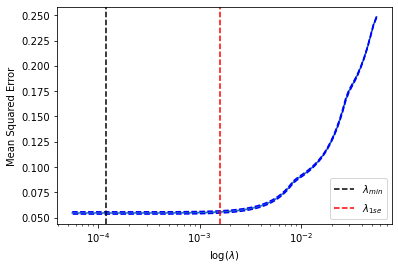

In [35]:
plot_lassoCV(lassocv,nfolds)

In [36]:
coeffnames = list(algo_ads_X.columns)
coeffnames.insert(0,'(Intercept)')
coeffnames = np.array(coeffnames)
get_coef(lassocv,1,coeffnames)

,0,1
0,(Intercept),-0.043951
1,recency_3,0.219018
2,recency_4,0.199242
3,recency_5,0.203544
4,recency_6,0.202657
5,recency_7,0.20868
6,recency_8,-0.022707
7,recency_9,0.009757
8,recency_10,-0.507365
9,frequency_2,0.493039


**A:** We find an inverted-U shape for recency and frequency, i.e., consumers with intermediate values along either dimension are most likely to be exposed to an ad. We also retain some monetary value coefficients, but effect sizes are quite small.

#### Second Stage

**Q:** Run a cross-validated lasso where now revenue is the outcome variable and allow for separate coefficients for each different level (1 to 10) of each of the three different RFM variables. Are the selected variables different from the ones in the first stage? What variables should you include in the third stage? Plot the mean square error and print non-zero coefficients.

In [52]:
# Y variable for LASSO
Y_rev = algo_ads['revenue']

# We run CV Lasso
nfolds  = 10
#alphas = np.logspace(-6, 1, 250) #(start,stop, number of alphas)
lassocv_rev = LassoCV(alphas = None, cv = nfolds, max_iter = 10000) 
lassocv_rev.fit(X,Y_rev)

LassoCV(cv=10, max_iter=10000)

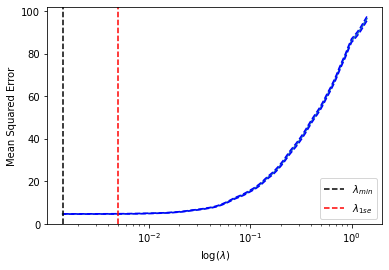

In [53]:
plot_lassoCV(lassocv_rev,nfolds)

In [54]:
coeffnames = list(algo_ads_X.columns)
coeffnames.insert(0,'(Intercept)')
coeffnames = np.array(coeffnames)
get_coef(lassocv_rev,1,coeffnames)

,0,1
0,(Intercept),20.589849
1,recency_2,0.802176
2,recency_3,2.789499
3,recency_4,3.766452
4,recency_5,4.719792
5,recency_6,5.952569
6,recency_7,6.991443
7,recency_8,7.450835
8,recency_9,8.597745
9,recency_10,8.285508


**A:** The first and second stage select the same variables. We will use those to run the last step.

#### Third Stage

**Q:** What is your final estimate for the effect of ad exposure on revenue?


In [55]:
# first, we select the variables that we will use in the ols 
ols_data = algo_ads[['revenue','ad_exposure','recency','frequency','monetary_value']]
ols_data = pd.get_dummies(ols_data, columns=['recency','frequency','monetary_value'],drop_first=True)
#We don't drop any variables because in stage 2 lasso selects all of them
ols_data

,revenue,ad_exposure,recency_2,recency_3,recency_4,recency_5,recency_6,recency_7,recency_8,recency_9,...,frequency_10,monetary_value_2,monetary_value_3,monetary_value_4,monetary_value_5,monetary_value_6,monetary_value_7,monetary_value_8,monetary_value_9,monetary_value_10
0,50.108791,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,46.752033,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,58.066216,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,36.502415,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,41.131004,1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,54.037663,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3996,60.444511,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
3997,48.514729,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3998,43.664574,1,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0


In [56]:
# second, we run the ols
all_columns = "+".join(ols_data.columns[1:])
my_formula = "revenue~" + all_columns

third_stage_reg  = smf.ols(formula = my_formula, data = ols_data).fit()
print(third_stage_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     3229.
Date:                Sun, 06 Mar 2022   Prob (F-statistic):               0.00
Time:                        23:15:45   Log-Likelihood:                -8480.7
No. Observations:                4000   AIC:                         1.702e+04
Df Residuals:                    3971   BIC:                         1.720e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            20.3697      0.17

**A:** 3.1837 is our estimate of the effect of ad exposure on revenue. This is statistically significant.

**Q:** What do you conclude with regards to the effectiveness of email advertising?

**A:** After accounting for the targeting algorithm, email marketing appears to be quite effective.